# Spectroscopy Module

**Lecturer:** Robert Quimby<br>
**Jupyter Notebook Authors:** Robert Quimby, Cameron Hummels, & Matt Hankins

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2019.html

## Objective

Extract a 1-D spectrum from a 2-D image of a long-slit spectrum, determine wavelength solution, and then measure the redshift of the target.


## Key steps
- determine the mapping between pixel coordinates and lines of constant wavelength
- create and subtract a 2D model of the sky background from the science image
- determine the mapping between pixel coordinates and lines of constant spatial position
- extract (sum) the background subtracted target counts in each wavelength bin
- determine the wavelengths for each wavelength bin
- identify line features in the extracted spectrum and use the known rest wavelength to compute a redshift
- normalize a flat field image wavelength bin by wavelength bin and correct the images for pixel-to-pixel efficiencies 
- extract a spectrum of a "standard star" with a known flux densities
- use the standard star spectrum to calibrate the instrumental response function
- use the response function to convert the target counts into flux densities
- identify telluric absorption features in the standard star spectrum and correct the target spectrum for these absorption bands

*Note we may not get through all of these steps today. We will do our best to get as far down the list as we can and leave any remaining steps for you as homework.

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* pyds9

### External packages
* ds9 http://ds9.si.edu/site/Home.html 

In [1]:
# python modules that we will use
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d
from scipy.interpolate import LSQBivariateSpline, LSQUnivariateSpline
from scipy.optimize import fmin
from scipy.optimize import least_squares
import pickle

%matplotlib inline
import matplotlib.pylab as plt
import os
import subprocess

In [2]:
# optional launch DS9 for displaying image data
import pyds9
ds9 = pyds9.DS9()

ModuleNotFoundError: No module named 'pyds9'

In [3]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (15, 7)

In [4]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

## Test dependencies

In order for this jupyter notebook to function correctly, we must have some external software installed, as described above.  The following step assures that these are installed properly before getting to the rest of the content of this lesson.

In [5]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0
    
dependencies = [('ds9', 'DS9')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.") 

===ds9/DS9 IS NOT YET INSTALLED PROPERLY===
0 out of 1 external dependencies installed properly.

Please correctly install these programs before continuing by following the instructions in README.md.


## Scipy bug check

In [6]:
# test if spline fitting works
x = np.array([0, 1, 2, 2, 3, 4])
y = np.array([0, 1, 2, 2, 3, 4])
try:
    spl = LSQUnivariateSpline(x, y, []) # new scipy crashes here because of duplicate x=2 values
    SPLINE_WORKS = True
    print('Congratulations! Your version of scipy has 1D spline fitting')
except ValueError:
    SPLINE_WORKS = False
    print('Nuts! Your version of scipy does not do proper 1D spline fitting.')

Nuts! Your version of scipy does not do proper 1D spline fitting.


In [7]:
# *** HACK! -- HACK! -- HACK! ***
if SPLINE_WORKS is False:
    from scipy.interpolate import LSQUnivariateSpline as real_LSQUnivariateSpline

    # re-define LSQUnivariateSpline; this runs VERY slow!
    def LSQUnivariateSpline(x, y, t, weights=None):
        # x must be **strictly** increasing
        # so remove (average over) duplicates
        uniqx = np.unique(x)
        newy = np.zeros(uniqx.shape)
        if weights is not None:
            newweights = np.zeros(uniqx.shape)
        else:
            newweights = None
            
        for i in range(uniqx.size):
            w = (x == uniqx[i])
            newy[i] = np.mean(y[w])
            if weights is not None:
                newweights[i] = np.mean(weights[w]) # probably not right...
                
        return real_LSQUnivariateSpline(uniqx, newy, t, newweights)

## Load the 2-D science Frame

In [10]:
# load the 2D science image data
image = fits.getdata(os.path.join(data_dir,'spec_sci.fits'))

In [11]:
# determine the image pixel distribution (used for displaying below)
sample = sigma_clip(image)
vmin = sample.mean() - 1 * sample.std()
vmax = sample.mean() + 3 * sample.std()

/home/venterh/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/venterh/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:4216: RuntimeWarning: invalid value encountered in multiply
  getdata(other)))


/home/venterh/miniconda3/lib/python3.7/site-packages/matplotlib/image.py:414: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


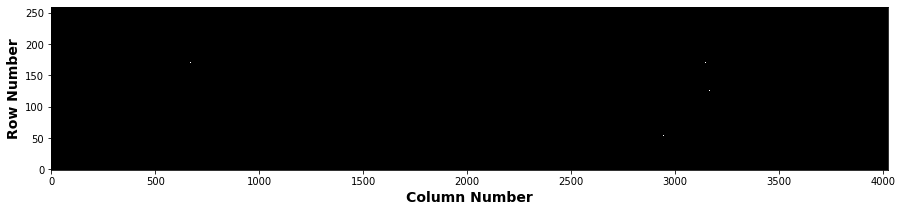

In [12]:
# show the image using matplotlib's `imshow` function
plt.figure(figsize=(15, 3))
plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
plt.xlabel('Column Number')
plt.ylabel('Row Number');

In [13]:
# optional: display image in DS9
ds9.set('frame 1')
ds9.set_np2arr(image)
ds9.set('scale zscale');

NameError: name 'ds9' is not defined

Take a look at the science image above. The supplied `spec_sci.fits` image is the red channel of a Keck/LRIS spectrum taken in 2014. The image has already been process to remove bias, and the image has been trimmed and rotated (what we will call "rows" are actually columns on the CCD). This science image is actually a combination of two individual exposures that has been filtered to remove **most** (but not quite all) cosmic ray events. 

Notice the vertical bands of light. These are the sky lines. The spectrum runs from about 5000 Angstroms on the left to about 10000 Angstroms on the right (you will determine the exact range below!). Notice that there is a significantly higher density of sky lines in the near infrared. Many of these lines in the infrared are caused by different molecules in Earth's atmosphere. In particular O-H bonds are the primary culprit for sky lines beyond ~750 angstroms. Later we'll have a closer look at the sky lines to examine the wavelength solution for the spectra. 

Notice the two horizontal bands of light. The lower band is the target (a small galaxy), and the upper band is a second object in the slit. If you look closely at the lower band (the target trace), you will see a number of emission lines. You will use these to determine the target redshift.

## Set up some variables for later use

How big is the image? What are the pixel coordinates near the center of the image? Create 1-D and 2-D arrays with indices for each axis.

In [14]:
# get the a pixel coordinate near the image center
ny, nx = image.shape
cy, cx = ny//2, nx//2

# create 1d arays of the possible x and y values
xs = np.arange(nx)
ys = np.arange(ny)

# pixel coordinates for each pixel
yvals, xvals = np.indices(image.shape)

## Find the rows dominated by sky light (exclude rows with object light, bad rows)

We can use the sky lines to map out lines of constant wavelength. To do this it is best to exclude portions of the image that are affected by light from the target trace, etc. 

To find the rows affected by the object traces, we can just marginalize over all the columns to determine the average profile and then note where this is significantly above the background average.

In [15]:
# compute the row averages and normalize so that the background is near 0 and the peaks are near 1
rowaverage = ???

plt.plot(ys, rowaverage)
plt.xlabel('Row Number (y-coordinate)'), plt.ylabel('Normalized Row Average')
plt.grid();

SyntaxError: invalid syntax (<ipython-input-15-3ef901ce9d01>, line 2)

#### Notes
* the plot above should show peaks in the rows containing object light
* there are some bad rows near the edges of the image
* other rows also show significant deviations from the median and should not be used

Based on the plot above, record the row coordinates (`ys`) that are brighter that some threshold, say 20% of the profile peak. To be conservative, also include the 5 rows above and 5 rows below.

Then create a 2D boolean mask that is `True` for pixels that are dominated by sky light and `False` for other pixels.

In [20]:
# find the rows with object light
objrows = ys[???]

# add some margin to object rows
ngrow = ??? # number of rows to include above and below object rows
newobjrows = []
for row in objrows:
    newobjrows.extend([row + i for i in np.arange(-ngrow, ngrow + 1)])
objrows = np.unique(newobjrows)

# mask to mark sky rows
skymask = np.ones(image.shape, dtype=bool)
skymask[objrows, :] = False

# also exclude bad rows
badrows = ys[rowaverage < -0.05]
skymask[badrows, :] = False

# rows with mostly sky background light
skyrows = ys[skymask.mean(axis=1) == 1]

TypeError: 'numpy.int64' object is not iterable

With the object traces and bad rows masked, we can also check for cosmic rays and mask these as well. To do this we calculate the median value and standard deviation along each column and then reject pixels that are more than a certain number (typically 3-5) of standard deviations away from the median. These deviant pixels are then noted on the `skymask`.

In [17]:
# median (unmasked) sky spectrum and standard deviation
medspec = ???
stdspec = ???

# exclude deviant pixels from the skymask
pull = (image - medspec) / stdspec
w = pull > 5
skymask[w] = False

SyntaxError: invalid syntax (<ipython-input-17-5eba5fef5c9e>, line 2)

In [18]:
# show the mask
plt.figure(figsize=(15, 3))
plt.imshow(skymask, origin='lower', aspect='auto');

NameError: name 'skymask' is not defined

<Figure size 1080x216 with 0 Axes>

In [ ]:
# optional: display the mask in DS9
mask = np.zeros(image.shape)
mask[skymask] = 1

ds9.set('frame 1')
ds9.set_np2arr(image)
ds9.set('frame 2')
ds9.set_np2arr(mask)
ds9.set('lock frame image');

## Let's look at a small section of image up close

In [ ]:
# cut out a small image "stamp" near the center of the frame
row = cy
col = cx
hwidth = 50
stamp = image[:, col - hwidth : col + hwidth]
ys_stamp = yvals[:, col - hwidth : col + hwidth]
xs_stamp = xvals[:, col - hwidth : col + hwidth]

In [ ]:
# show the image stamp
plt.figure(figsize=(15, 5))
extent = (xs_stamp.min(), xs_stamp.max(), ys_stamp.min(), ys_stamp.max())
plt.imshow(stamp, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
plt.xlabel('Column Number')
plt.ylabel('Row Number');

Recall the vertical bands are sky lines that mark lines of constant wavelength. Notice that these do not run perfectly parallel to the columns. Rather, the `x` coordinate for a given wavelength will be a function of the row number. 

As the plot should demonstrate, the lines of constant wavelength are slightly tilted with respect to the columns and there is also slight curvature. Thus we can approximate that the `x` coordinate for a given wavelength will be a quadratic function of the row number.

#### Note
Because wavelength varies along a given column, if we simply plot the counts in each pixel against each pixel's column number then we get a range of values in each column:

In [ ]:
# plot stamp values against column numbers
plt.plot(xs_stamp.ravel(), stamp.ravel(), 'r.');
plt.xlabel('Column Number'), plt.ylabel('Counts');

## Map out lines of constant wavelength (determine the wavelength for each pixel)

We can model the change in wavelength coordinate in arbitrary units, `dl`, from the wavelength at some reference pixel in terms of the offsets, `dx` and `dy` from the reference pixel.

We can then write down a function that takes our model parameters (the slope and curvature of the lines of constant wavelength with respect to the columns), the offsets in the x and y coordinates, `dxs` and `dys`, respectively, and returns the wavelength offset from the reference pixel (i.e. `dx = dy = 0`).

In [ ]:
def get_dl_model(params, dxs, dys):
    return dxs + params[0] * dys + params[1] * dys ** 2

To see how this works, make a guess for the slope and curvature parameters and try plotting the wavelength offsets from our reference pixel (the one at `x=col` and `y=row`).

In [ ]:
# pixel offsets from the refernece pixel
dxs = xs_stamp - col
dys = ys_stamp - row

# parameter guess
guess = ???

# get the wavelength offsets and plot vs. counts
dls = get_dl_model(guess, dxs, dys)
plt.plot(dls.ravel(), stamp.ravel(), 'r.')
plt.xlabel('Wavelength Offset')
plt.ylabel('Counts');

You should notice that for the right choice of model parameters, the vertical scatter is significantly reduced. This demonstrates one way to decide on the best model parameters: find the model parameters that minimize the vertical scatter. But how do we measure this scatter?

## Fit a spline to the counts spectrum above

Given the data above (the wavelength offsets, `dls`, and the stamp count values) we can fit a spline to the resulting curve above and then subtract this off from the curve and measure the scatter. Notice that for every column we get a lot of samples (`ny` to be precise). Thus we can set the spline knots every pixel (or even closer).

We can define a function that will return the best fit spline object (in the least-squares sense) for our data.

In [ ]:
def get_profile_spl(dls, stamp):
    # need to sort the data (and weights) so that the x values are increasing
    x, y = dls.ravel(), stamp.ravel()
    weights = np.sqrt(np.abs(y)) # not technically optimal for coadded data, but ok
    wsort = x.argsort()
    x, y, weights = x[wsort], y[wsort], weights[wsort]

    # set locations for spline knots
    t = np.linspace(x.min() + 1, x.max() - 1, np.int(x.max() - x.min()))
    spl = LSQUnivariateSpline(x, y, t, weights)
    return x, y, spl

Lets see how good this looks.

In [ ]:
# fit a spline to the data and plot
x, y, spl = get_profile_spl(dls, stamp)

fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y, 'r.')
axarr[0].plot(x, spl(x))
axarr[1].plot(x, y - spl(x), 'r.')
plt.ylim(-200, 200)
plt.xlabel('Wavelength Offset');

#### Notice
 * the counts may vary along the slit (both because of real spatial variations and, more importantly, we have not accounted for efficiency variations along the slit), so there may be some biased scatter
 * the parameter guess above may be imperfect resulting in systematic residuals (we can minimize these below)

## Minimize residuals from the spline model to determine the best tilt/curvature model

We need a metric to determine how well the spline fits the data. We could take a simple sum of the squares of the residuals or weight these by the expected poison noise to determine a $\chi^2$ value.

In [ ]:
def check_dl_model(params, dxs, dys, stamp):
    dls = get_dl_model(params, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    chisq = np.sum((stamp - spl(dls)) ** 2 / np.sqrt(np.abs(stamp)))
    return chisq / (stamp.size - len(params))

In [ ]:
# see how good our guess is
check_dl_model(guess, dxs, dys, stamp)

Now we just need to change the model parameters to minimize the residuals. We can use `fmin` for this.

In [ ]:
if SPLINE_WORKS is False:
    print("the hacked version of LSQUnivariateSpline is VERY slow...this cell might take a minute or more to run!")

# get the best model parameters for this stamp
params = fmin(check_dl_model, guess, args=(dxs, dys, stamp))
print("best model parameters are", params)

You can plug in these parameters for your `guess` above and re-run the cells to check the residuals if you want.

## Find the lines of constant wavelength at other parts of the 2-D image

The tilt/curvature between lines of constant wavelength and the columns can vary across the spectrum. So far we have only determined it for a small portion of the image. Now we can apply the same techniques to map out the relative wavelengths shifts across the image.

To do this, we need to pick a width (number of columns) within which we can expect to get enough sky lines to do the mapping. Considering the left side (shorter wavelength or "blue" portion) of the spectrum, we can set the width at about 400 columns. (Note it is possible to vary the width across the image to take advantage of the extra wavelength information in the near-IR due to the higher density of sky lines, but this is not required).

In [ ]:
# define the column centers for the stamps
hwidth = 200 # width = 2 * hwidth + 1
cols = np.arange(hwidth, nx, 2 * hwidth)
cols

As above, map out the wavelength shits along columns, one stamp (image section) at a time. It is best to use the sky mask we defined above and possibly some outlier rejection to fend off deviant pixels.

Notice that the code cell below will keep track of the wavelength offsets for all columns, but really we only need the central columns defined above.

#### Note: the code below might take some time to run. If you are using the hacked version of LSQUnivariateSpline, you should probably skip this cell and load the solution below

In [ ]:
# reference wavelength offsets to the center row
row = cy

# define a 2D array to hold the wavelength offsets for each pixel
lambdas = np.zeros(image.shape) 

# loop over each central column
for col in cols:
    print('col = ', col)
    
    # slice the data
    inds = np.s_[:, col - hwidth : col + hwidth]
    stamp = image[inds]
    mask = skymask[inds]
    dys = yvals[inds] - row
    dxs = xvals[inds] - col

    # initial fit
    params = fmin(check_dl_model, guess, args=(dxs[mask], dys[mask], stamp[mask]))
    
    # check for outliers
    dls = get_dl_model(guess, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    model = spl(dls)
    pull = (stamp - model) / np.sqrt(np.abs(model))
    w = (pull < 5) & mask
    params2 = fmin(check_dl_model, params, args=(dxs[w], dys[w], stamp[w]))

    # record
    lambdas[inds] = get_dl_model(params2, dxs, dys) + col


In [ ]:
if SPLINE_WORKS is False:
    lambdas = pickle.load(open(os.path.join(data_dir,'lambdas.dat'), 'rb'))

# **********************
# save the lambdas
#pickle.dump(lambdas, open('lambdas.dat', 'wb'))
# **********************

Look at a few rows and see how the wavelength offsets vary with column number. We can fit a low-order polynomial to these.

In [ ]:
# just plot offsets for a few of the rows across the image
order = ???
for y in range(10, ny, 50):
    p = plt.plot(cols, lambdas[y, cols] - xs[cols], 'o')
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    plt.plot(xs, np.polyval(c, xs), c=p[0].get_color(), label='row {}'.format(y))
plt.legend()
plt.xlabel('Column Number')
plt.ylabel('Wavelength Offset from Middle Row');

You may notice that the tilt (the wavelength difference in a given column between the first row and the last row) increases as we move to larger column numbers. Make sure the order is large enough to follow the trends without over fitting the data (i.e. there should not be noticeable wiggles between data points).

Now we can fit for every row. We could do a 2D fit to all the data at once, but simply fitting row by row works here.

In [ ]:
# get the lambda values for the entire image (fit)
lambdafit = np.zeros(image.shape)
for y in range(ny):
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    lambdafit[y, :] = np.polyval(c, xs) + xs

Now for the fun part! We have wavelength values relative to the central row (in arbitrary units) for every pixel on the image, which means we can do some cool tricks.

## Model the 2D sky

We want to measure the light from our target, not the night sky, so lets make those sky lines disappear! We can do a 2-D spline fit to the sky background pixels to create a sky model. As above, we have about `ny` measurements in each wavelength bin, so we can set the knot points along the wavelength direction about every pixel (or even less!). We do not expect strong variations in the sky brightness along the slit, so we can simply fit a low order polynomial along this direction (which we will approximate for now using the y-coordinates).

In [ ]:
# function to fit a 2D spline
def fit_sky(xvals, yvals, image, ky=1, dx=0.5):
    # select knot points in the x (wavelength) direction
    tx = np.arange(xvals.min() + 2, xvals.max() - 2, dx)
    
    # select knot points in the y (spatial) direction
    ty = [] # if there are no knots, the fit will be a poly nomial of degree ky
    
    # fit the 2D spline
    return LSQBivariateSpline(xvals.ravel(), yvals.ravel(), image.ravel(), tx, ty, ky=ky)

In [ ]:
# use the (unmasked) sky background pixels and fit the 2D spline
skyfit = fit_sky(lambdafit[???], yvals[???], image[???])

# evaluate the 2D sky at every pixel
sky = skyfit.ev(lambdafit, yvals)

In [ ]:
# plot the image, sky model, and differece (and/or display in DS9)
ds9.set('frame 1')
ds9.set_np2arr(image)
ds9.set('frame 2')
ds9.set_np2arr(sky)
ds9.set('frame 3')
ds9.set_np2arr(image - sky);

Notice how well the object trace stands out now. Analogous to the sky lines, the object trace is slightly tilted with respect to the rows. Thus to extract our spectrum we need to map out the y-values where the trace is centered as a function of column number.

## Locate object trace

There are actually two object traces in our data, so let's simultaneously find the centers of each of these. The object that makes the lower trace is actually a galaxy, but we can approximate its distribution of light along the slit with a Gaussian function, and we can do the same for the other object. Thus our profile model will be the sum of two Gaussians. 

In [ ]:
def get_profile_model(params, ys):
    a1, cy1, sigma1, a2, cy2, sigma2 = params
    
    p1 = np.exp(-(ys - cy1)**2 / 2 / sigma1**2) 
    p1 /= p1.max()
    
    p2 = np.exp(-(ys - cy2)**2 / 2 / sigma2**2) 
    p2 /= p2.max()

    return a1 * p1 + a2 * p2

Now that we have our model, we can make a guess at the parameters and check by eye how well these represent the data. Change the guess until the model is a reasonably close match to the data (this need not be perfect).

In [ ]:
# get the median for each row
profile = np.median(image - sky, axis=1)

# starting guess for the profile model
guess = ???
model = get_profile_model(guess, ys)

plt.plot(ys, profile)
plt.plot(ys, model);
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts');

Of course, we can improve the model by minimizing the model residuals (or $\chi^2$/dof).

In [ ]:
def get_profile_chisq(params, ys, profile):
    model = get_profile_model(params, ys)
    return np.sum( (profile - model)**2 / np.sqrt(np.abs(profile)) ) / (profile.size - len(params))

In [ ]:
# fit for the best model
params = fmin(get_profile_chisq, guess, args=(ys, profile))
print("best fit parameters are", params)

model = get_profile_model(params, ys)
plt.plot(ys, profile)
plt.plot(ys, model)
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts')
plt.grid();

We could fit a more complex model that accounts for the vertical shift of the traces with column numbers, but here we simply divide the image up into sections by wavelength and find the Gaussian centroids in each of these.

In [ ]:
# fit the profile centered at these columns
hwidth = 50
cols = np.arange(hwidth, nx + 1, 2 * hwidth)

ycenter = np.zeros( (len(cols), 2) )
for icol, col in enumerate(cols):
    stamp = (image - sky)[:, col - hwidth : col + hwidth]
    profile = np.mean(stamp, axis=1)
    params = fmin(get_profile_chisq, guess, args=(ys, profile))
    ycenter[icol, :] = params[[1, 4]]

Lets see how the y-center of our target's trace varies with column number. We can fit a polynomial to the trend and use this to estimate the y-center at any column.

In [ ]:
# fit the relation with a polynomial
ind = 0 # which trace 0 or 1?
t_order = ???
trace_c = np.polyfit(cols, ycenter[:, ind], t_order)
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(cols, ycenter[:, ind], 'ro')
axarr[0].plot(xs, np.polyval(trace_c, xs), 'r')
axarr[0].axes.set_ylabel('y-coordinate')
axarr[1].plot(cols, ycenter[:, ind] - np.polyval(trace_c, cols), 'ro')
axarr[1].axes.set_ylim(-0.5, 0.5)
axarr[1].axes.set_ylabel('Fit Residual (pixels)')
plt.xlabel('Column Number');

The typical residuals should be a small fraction of a pixel. 

**Note** we are fitting a Gaussian model to a non-Gaussian (galaxy) profile, so the center value may be systematically offset.

Now we can get the pixel offsets from the object trace for every pixel in the image. To properly account for non-linearities along the trace (i.e. the pixel scale may be 0.1 arcsec per y-pixel on the blue side but 0.12 arcsec per pixel on the red side) we could use the second object trace and the relative wavelength information, but here we will simply assume a simple linear relation.

In [ ]:
# position offsets from the object trace (defined to be at slitpos = 0)
slitpos = yvals - np.polyval(trace_c, yvals)

## Spatial profile of the target

Next, determine the spatial profile of the target and stretch this over the whole 2D image to make a weight map for later use.

The brightness of the target will vary as a function of wavelength, so to determine the profile we can normalize the counts in each wavelength bin using the counts at the trace center (or our approximation there of).

In [ ]:
# subtract the sky
nosky = image - sky

# normalize to the pixel brightness at the trace center
yinds = (np.round(np.polyval(trace_c, xs))).astype(int)
normed = nosky / ???

Fit a spline to the normalized profile

In [ ]:
# get 1D arrays with the positions along the slit and the normalized counts
pos = slitpos.flatten()
counts = normed.flatten()

# sort by slit position
sort_inds = pos.argsort()
pos, counts = pos[sort_inds], counts[sort_inds]

# fit a spline to model the spatial profile
t = np.linspace(pos.min() + 2, pos.max() - 2, ny // 2) # spline knot points
profile_spl = LSQUnivariateSpline(pos, counts, t)

# remove outliers and re-fit
diff = counts - profile_spl(pos)
sample = sigma_clip(diff)
w = ((np.abs(diff) / sample.std()) < 5) & np.isfinite(diff)
profile_spl = LSQUnivariateSpline(pos[w], counts[w], t)

In [ ]:
# plot the target profile
#plt.plot(pos, counts, 'r.')
plt.plot(pos, profile_spl(pos) )
plt.xlim(-40, 50)
#plt.ylim(-2, 4)
plt.grid();

Calculate the profile for every column to make a 2D profile image.

In [ ]:
# create the profile image
profile_image = profile_spl(???)

# de-weight negative values in provile_image
profile_image[profile_image < 0] = 0

In [ ]:
# display the result
ds9.set('frame 4')
ds9.set_np2arr(profile_image);

## Extract the target spectrum (basic version)

We have located the target trace, the sky background has been removed, so all that is left to do is sum up the counts in each wavelength bin in some aperture. We can pick any size wavelength bin we like, but at this phase it is common to use the native pixel scale to set the binning. If the target extends over many pixels in the spatial direction or the tilt/curvature of the lines of constant wavelength is large, you may have to take into account the changes in wavelength with row number. But for the supplied data the change in wavelength is not significant along the short extraction window, so we can simply sum along columns.

In [ ]:
# select which rows to sum
w = (slitpos > ???) & (slitpos < ???)
ymin, ymax = yvals[w].min(), yvals[w].max()

# calculate the sum
spec_basic = ???

# sky background
skybg_basic = ???

# plot the extracted spectrum
plt.plot(xs, spec_basic);

## Optimal extraction

We can weight the extraction using the spatial profile we calculated above to limit the noise from pixels that are dominated by the sky background. This proces is analogous to PSF-fitting in 2D image data, which is an improvement over an aperture extraction which essentially assume a 'top-hat' weighing scheme. For this exersize we will simply calculate a weighted average in each wavelength bin rather than fitting a model to the data. Using our basic extraction above we can determine the bias between the sum and the weighted average and then use this to re-scale the weighted average, because ultimately we want the sum of the counts from the target, not the average in each wavelength bin.

In [ ]:
# calculate the weighted average (for each column)
spec_opt = ???

# calculate the bias factor needed to scale the average to a sum
bias_factor = np.median(spec_basic / spec_opt)
spec_opt *= bias_factor

# same for the sky background
skybg_opt = ???
bias_factor_sky = np.median(skybg_basic / skybg_opt)
skybg_opt *= bias_factor_sky

# plot the extracted spectrum
plt.plot(xs, spec_basic, label='basic extraction')
plt.plot(xs, spec_opt, label='optimal extraction')
plt.legend()
#plt.ylim(0, 2000);
#plt.yscale('log')

If you look closely you should see that the basic extraction is noisier than the optimal.

## Wavelength solution

Up to now we have been working with relative wavelengths. Now we will use the emission lines to calibrate these into absolute wavelengths. 

There are several ways to do this. One method is to match the sky lines to a published atlas to determine the identity of several lines and then use the known wavelengths of these to determine the relative to absolute mapping function.

Instead of working with individual lines, we can instead find a mapping that matches our extracted sky spectrum to a reference spectrum with a calibrated wavelength axis. Ideally this reference should be matched in spectral resolution (and spectral response) to the data at hand. This module includes such a reference spectrum, which is a version of the [UVES high-resolution night sky spectrum](https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html) convolved to roughly match the resoultion of the Keck/LRIS data.

In [ ]:
# re-scale the sky spectrum so that the max counts are around 1 for convience
bgspec = skybg_opt / skybg_opt.max()

In [ ]:
# load the reference sky spectrum (conviently convolved to approximatley the spectral resulution of our data)
skyref = np.genfromtxt(os.path.join(data_dir,'UVES_nightsky_lowres.dat'), names='wav, flux')

Plot the reference and extracted sky spectra on two separate plots and adjust the wavelength range of the reference spectrum until the two roughly match. This will help you see the mapping between column numbers and wavelengths.

In [ ]:
# compare the reference spectrum and the extracted sky spectrum
fig, axarr = plt.subplots(2)
axarr[0].plot(skyref['wav'], skyref['flux'])
axarr[0].axes.set_ylabel('Flux Density ($10^{16} f_{\lambda}$)')
axarr[0].axes.set_xlabel('Wavelength ($\AA$)')

# adjust the wavlength range to approx. match the extracted sky spectrum range
axarr[0].axes.set_xlim(???)

# plot the extracted sky spectrum 
axarr[1].plot(xs, bgspec)
axarr[1].axes.set_ylabel('Counts')
axarr[1].axes.set_xlabel('Column Number');

By scaling the extracted counts to roughly match the reference spectrum and shifting/scaling the column number values to match the reference spectrum wavelengths, we can determine column number to wavelength mapping.

Let's define a function that takes our column numbers and counts spectra and returns a spectrum with wavelengths and fluxes that roughly match the reference spectrum. Note you usually match a model to the data, but here we go the other way.

If we fit the extracted spectrum over a limited wavelength range, we can approximate the mapping with a quadratic function. 

In [ ]:
def model_sky(params, dx, counts):
    wav0, a, b, scale, c0 = params
    
    dtype = []
    dtype.append(('wav', float))
    dtype.append(('flux', float))
    model = np.zeros(counts.shape, dtype=dtype)
    model['wav'] = wav0 + a * dx + b * dx**2
    model['flux'] = c0 + scale * counts
    
    return model

In [ ]:
# roughly match column values to wavelength values
col = 2000
wav = ???
params = (wav, ???)
model = model_sky(params, xs - col, bgspec)

plt.plot(model['wav'], model['flux'], label='Extracted Sky Background')
plt.plot(skyref['wav'], skyref['flux'], label='Reference Sky Spectrum')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts or Flux')
plt.xlim(???)
plt.legend();

You may find that over the full wavelength range the quadratic mapping is not sufficient. One way to handle this would be to adopt a higher order mapping function. Instead, we can use the quadratic function to find the mapping over a number of sections of limited wavelength range.

The procedure is similar to what has already been done above: make an initial guess for the model parameters and then minimize the difference between the scaled model and the reference spectrum.

In [ ]:
# we must interpolate the reference spectrum to the model wavelengths
skyref_interp = interp1d(skyref['wav'], skyref['flux'], bounds_error=False)

def get_sky_difference(params, dx, specdata, skyatlas):
    model = model_sky(params, dx, specdata)
    
    # residual
    res = model['flux'] - skyref_interp(model['wav'])
    
    return np.sum(res**2 / np.sqrt(np.abs(model['flux'])))

Select sections of the extracted spectrum to fit. Since there is a lower density of lines in the blue (left) portion of the spectrum, we need larger bins to ensure we have sufficient information to fit.

In [ ]:
cols = [200 * (i + 1) for i in range(8)]
cols.extend([max(cols) + 100 * (i + 1) for i in range(51)])
cols = np.array(cols)

hwidths = (cols[1:] - cols[:-1]) // 2
cols = cols[:-1]
w = (cols + hwidths) < nx
cols = cols[w]
hwidths = hwidths[w]
cols, hwidths

Set up an array to hold the best-fit parameters from each section.

In [ ]:
nparams = 5
fitparams = np.zeros((cols.size, nparams)) + np.nan

Write a function to show the fitting results.

In [ ]:
def plot_sky_model(skyref, model):
    plt.plot(model['wav'], model['flux'], label='Extracted Sky Background');
    plt.plot(skyref['wav'], skyref['flux'], label='Reference Sky Spectrum');
    plt.xlim(model['wav'].min(), model['wav'].max());
    plt.ylim(model['flux'].min() - 0.25, model['flux'].max() + 0.25)

    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Scaled Counts or Flux')
    plt.legend();

Start by guessing a solution for one of the middle sections

In [ ]:
ind = 11
col = cols[ind]
hwidth = hwidths[ind]
guess = ???
w = (xs > (col - hwidth)) & (xs < (col + hwidth))
model = model_sky(guess, xs[w] - col, bgspec[w])
plot_sky_model(skyref, model)

In [ ]:
# fit for the best mapping parameters
bestparams = fmin(get_sky_difference, guess, args=(xs[w] - col, bgspec[w], skyref), maxiter=10000)
print("best-fit parameters are", bestparams)

model = model_sky(bestparams, xs[w] - col, bgspec[w])
plot_sky_model(skyref, model)

Keep track of the best-fit parameters

In [ ]:
# initial solution
fitparams[ind, :] = bestparams

Now we can use this first solution to guess starting values for adjacent sections. We can write a function to help automate the process.

In [ ]:
def fit_another(xs, cols, hwidths, fitparams, i, plot=True):
    col = cols[i]
    hwidth = hwidths[i]
    
    # find the closest matching index with a valid fit
    inds = np.arange(cols.size)
    w = np.isfinite(fitparams[:, 0]) & (inds != i)
    iref = inds[w][np.argmin(np.abs(inds[w] - i))]
    print("reference index is ", iref)

    # get the wavelength guess
    if w.sum() == 0:
        print("not enough data to make guess...bye!")
        return
    if w.sum() < 4:
        guess = fitparams[iref, :].copy()
        guess[0] = guess[0] + guess[1] * (cols[i] - cols[iref])
    else:
        if w.sum() > 9:
            order = 3
        elif w.sum() > 6:
            order = 2
        else:
            order = 1
        print("order is", order)
        cwav = np.polyfit(cols[w], fitparams[w, 0], order)
        cdwav = np.polyfit(cols[w], fitparams[w, 1], order)
        cscale = np.polyfit(cols[w], fitparams[w, 3], order)
        guess = (np.polyval(cwav, col), np.polyval(cdwav, col), 0.0, np.polyval(cscale, col), 0.0)
    print("guess is", guess)

    w = (xs > (cols[i] - hwidths[i])) & (xs < (cols[i] + hwidths[i]))
    output = fmin(get_sky_difference, guess, args=(xs[w] - cols[i], bgspec[w], skyref)
                  , full_output=True, disp=False, maxiter=10000)
    if output[4] == 0:
        fitparams[i, :] = output[0]
        print(output[0])

        if plot:
            model = model_sky(output[0], xs[w] - col, bgspec[w])
            plot_sky_model(skyref, model)
            plt.title('Fit to Section {}'.format(i))
    else:
        print("fit failed!")

Call the function above for sections adjacent to ones that have already been fit. Just run the cell below several times to step through different section indices. 

**Important: if the fit looks bad, reset the `fitparams` values for that index back to `np.nan`**

In [ ]:
#ind = 11
ind += 1
fit_another(xs, cols, hwidths, fitparams, ind)

Use the cell below to reset any sections with bad fits (there will probably be a few, especially near the blue end!).

To add more points at the blue end, you can repeat the manual guessing process above that you initially did for one of the middle sections. The regions near the Oxygen 5577 angstrom and 6300 angstrom lines are probably easiest to fit by hand.

In [ ]:
#ind = 4
print("deleting fit at index", ind)
fitparams[ind, :] = np.nan

You can use the cells below to check for outliers, which you should remove using the cell above.

If you get stuck, you can use the pre-computed `fitparams`, which is stored in the `fitparams.dat` file. Uncomment the code below to load it.

In [ ]:
# only if you get stuck:
#fitparams = pickle.load(open(os.path.join(data_dir, 'fitparams.dat'), 'rb'))

# **********************
# save wavelength fit results
#pickle.dump(fitparams, open(os.path.join(data_dir,'fitparams.dat'), 'wb'))
# **********************

Fit a low-order polynomial to the fit results to get the column number to wavelength mapping. Plot the residuals from the fit to check for outliers.

In [ ]:
order = ???
inds = np.arange(cols.size)
w = np.isfinite(fitparams[:, 0])
c = np.polyfit(cols[w], fitparams[w, 0], order)
plt.plot(inds[w], fitparams[w, 0] - np.polyval(c, cols[w]), 'ro');
plt.xlabel('Section Index')
plt.ylabel('Residual')
plt.grid();

Plot the column number to wavelength mapping directly and with the linear fit removed to see the non-linearities in the wavelength solution.

In [ ]:
fig, axarr = plt.subplots(2, sharex=True)

# relation between column number and wavelength
axarr[0].plot(cols[w], fitparams[w, 0], 'ro');
axarr[0].plot(xs, np.polyval(c, xs));
axarr[0].axes.set_xlabel('Column Number')
axarr[0].axes.set_ylabel('Wavelength ($\AA$)')

# plot the relation again with the linear term removed
remove_order = 1
axarr[1].plot(cols[w], fitparams[w, 0] - np.polyval(c[-(remove_order + 1):], cols[w]), 'ro');
axarr[1].plot(xs, np.polyval(c, xs) - np.polyval(c[-(remove_order + 1):], xs));
axarr[1].axes.set_xlabel('Column Number')
axarr[1].axes.set_ylabel('$\Delta \lambda$');

Now that we have a mapping from counts to wavelengths, we can apply this to the full spectrum.

In [ ]:
# apply the wavelength solution to the extracted spectrum
wavs = ???
plt.plot(wavs, spec_opt);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

## Determine redshift of target

The spectrum is now extracted and wavelength calibrated, so we are finally ready to do some science!

You should notice a number of strong emission lines in the spectrum. In particular, there is a very strong line around 7300 angstroms. What is a strong line that you might expect from a galaxy in the optical band? Using the observed wavelength and the known rest (laboratory) wavelength for this line you can determine the galaxy's redshift. 

To get a precise measurement of the line center, we need to fit a model to the data. A simple Gaussian fit should do for our purposes, so we need functions to generate the model and to evaluate how good the fit is so that we can find the best fitting parameters.

In [ ]:
def get_line_model(params, ys):
    a1, cy1, sigma1 = params
    
    p1 = np.exp(-(ys - cy1)**2 / 2 / sigma1**2) 
    p1 /= p1.max()
    
    return a1 * p1 

def get_line_chisq(params, ys, profile):
    model = get_line_model(params, ys)
    w = profile > 0
    return np.sum( (profile[w] - model[w])**2 / np.sqrt(np.abs(profile[w])) ) / (profile[w].size - len(params))

Limit the fit to the wavelengths dominated by the strong line and determine the central wavelength.

In [ ]:
minwav = ???
maxwav = ???
w = (wavs > minwav) & (wavs < maxwav)

guess = ???
params = fmin(get_line_chisq, guess, args=(wavs[w], spec_opt[w]), maxiter=10000)

tempwav = np.linspace(minwav, maxwav, 100)
model = get_line_model(params, tempwav)

plt.plot(wavs[w], spec_opt[w], drawstyle='steps-mid', label='extracted spectrum');
plt.plot(tempwav, model, label='model')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')
plt.legend();

Determine the redshift

In [ ]:
z = ???
print('redshift is z={:0.4f}'.format(z))

There are many more lines in the spectrum; you can use these to test/refine your redshift.

## Flat field data (Optional) 

To this point we have not corrected the data for pixel-to-pixel efficiencies (in other words, we have not flat-fielded the data). For many tasks this is actually not required, but if you have *good* flat field exposures available, flat fielding can improve the output data quality.

The key for spectroscopy is to note that the CCD response is wavelength dependent (you wouldn't use a U-band flat to process an I-band image, right?), and with spectra there are many wavelength bins to account for. Just as with photometry, we do not care so much how many counts we get in a given wavelength bin, we can just determine the average number in each wavelength bin and then divide by this average to get numbers close to 1.

In [ ]:
# load in the flat
flat = fits.getdata(os.path.join(data_dir,'spec_flat.fits'))

# display
ds9.set('frame 2')
ds9.set_np2arr(flat)

plt.plot(np.median(flat, axis=0));
plt.xlabel('Column Number')
plt.ylabel('Counts');

Notice that the average counts vary considerably with wavelength and there are even a few line features present in the data (there is air between the light source and the camera, and air can emit and absorb light!

Since we already know the relative wavelengths for each pixel, this is no problem. We can fit a spline to this profile (which is marginalized over slit position) to determine the typical number of counts in each wavelength bin and then divide each pixel by the appropriate value from the spline fit to normalize the counts.

#### Note: the cell below calls the LSQUnivariateSpline. If you are using the (VERY slow) hacked version, this may take some time! You can simply load the provided `flat_spl.dat` data file instead.

In [ ]:
# fit a spline
x = lambdafit.ravel()
y = flat.ravel()
weights = np.sqrt(np.abs(y)) 
wsort = x.argsort()
x, y, weights = x[wsort], y[wsort], weights[wsort]
t = np.linspace(x.min() + 1, x.max() - 1, nx)
if SPLINE_WORKS is False:
    spl = pickle.load(open(os.path.join(data_dir,'flat_spl.dat'), 'rb'))
else:
    spl = LSQUnivariateSpline(x, y, t, weights)

In [ ]:
# **********************
# save the flat spline
#pickle.dump(spl, open('flat_spl.dat', 'wb'))
# **********************

In [ ]:
# plot the spline
#plt.plot(x, y, 'ro');
plt.plot(x, spl(x))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

In [ ]:
# normalize the flat field 
normflat = ???

In [ ]:
ds9.set('frame 1')
ds9.set_np2arr(flat)
ds9.set('frame 2')
ds9.set_np2arr(normflat);

You can now divide the science images by this normalized flat to correct for pixel-to-pixel differences.

## Flux Calibration (Optional) 

Sometimes you may also want to scale the counts (by a wavelength dependent function) to determine the flux densities in each wavelength bin. To do this, you need to observe a target with a known flux density spectrum. A number of such calibrated standard stars are available and should be observed. Typically you cannot observe your target and a standard star simultaneously, so you need a photometric night in order to get the absolute scaling right. However, even with clouds you can often get the *relative* flux densities of your target.

In [ ]:
# extract standard star spectrum as above
stdimage = fits.getdata(os.path.join(data_dir, 'spec_std.fits'))

In [ ]:
# mask to mark sky rows
stdskymask = np.ones(stdimage.shape, dtype=bool)
stdskymask[objrows, :] = False

# also exclude bad rows
stdskymask[badrows, :] = False

# median (unmasked) sky spectrum and standard deviation
medspec = np.median(stdimage[skyrows, :], axis=0)
stdspec = np.std(stdimage[skyrows, :], axis=0, ddof=1)

# exclude deviant pixels from the skymask
pull = (stdimage - medspec) / stdspec
w = pull > 3
stdskymask[w] = False

In [ ]:
stdskyfit = fit_sky(lambdafit[stdskymask], yvals[stdskymask], stdimage[stdskymask])
stdsky = stdskyfit.ev(lambdafit, yvals)

In [ ]:
ds9.set('frame 1')
ds9.set_np2arr(stdimage)
ds9.set('frame 2')
ds9.set_np2arr(stdsky)
ds9.set('frame 3')
ds9.set_np2arr(stdimage - stdsky)

In [ ]:
# select which rows to sum
w = (slitpos > ???) & (slitpos < ???)
ymin, ymax = yvals[w].min(), yvals[w].max()

# calculate the sum
std_spec = ???

# plot the extracted spectrum
plt.plot(wavs, std_spec)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

The supplied standard star is called Feige 67. You can get a table of its flux densities from ESO (and other sources).

In [ ]:
# Download the data from ESO
dtype = []
dtype.append( ('wav', float) )
dtype.append( ('flux', float) ) # units are ergs/cm/cm/s/A * 10**16
dtype.append( ('eflux', float) )
dtype.append( ('dlam', float) )
calspec = np.genfromtxt('ftp://ftp.eso.org/pub/stecf/standards/okestan/ffeige67.dat', dtype=dtype)

In [ ]:
plt.plot(calspec['wav'], calspec['flux']);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$10^{16} * F_{\lambda}$');
plt.yscale('log');

In [ ]:
# fit a spline to the tabulated spectrum
t = np.arange(calspec['wav'][1], calspec['wav'][-2], np.int(np.median(calspec['dlam'])))
stdflux = LSQUnivariateSpline(calspec['wav'], calspec['flux'], t, calspec['eflux'])

In [ ]:
# get the counts to flux density ratios in each wavelength bin
# exclude significant line features (fluxes near these depend on spectral resolution)
ratios = std_spec / stdflux(wavs)
w = (wavs > calspec['wav'].min()) \
    & (wavs < calspec['wav'].max()) \
    & (np.abs(wavs - 7650) > 70) \
    & (np.abs(wavs - ???) > ???) \
    & (np.abs(wavs - ???) > ???) \

# fit a spline to the ratios to determine the response function
t = wavs[w][1:-2:???]
respfn = LSQUnivariateSpline(wavs[w], ratios[w], t)

plt.plot(wavs[w], ratios[w], 'ro')
xwav = np.linspace(wavs[w][1], wavs[w][-1], 1000)
plt.plot(xwav, respfn(xwav));
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Response Function (counts/$F_{\lambda}$)');

In [ ]:
# compare the tabulated and extracted flux densities (applying the response function)
plt.plot(calspec['wav'], calspec['flux'], label='Tabulated (published) Spectrum');
plt.plot(wavs, std_spec / respfn(wavs), label='Extracted Spectrum')
plt.xlim(5300, 9200) # standard star values are only tabulated out to ~9200 A
plt.ylim(0, 1000)

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.ylim(50, 1000)
plt.yscale('log')
plt.legend();

Now apply the response function to the target spectrum to get the flux calibrated spectrum.

In [ ]:
plt.plot(wavs, spec_opt / respfn(wavs))
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$');

## Removal of telluric features (Optional) 

The Earth's atmosphere strongly absorbs light in bands near 7600 angstroms (A-band) and 6900 angstroms (B-band), and also in a number of other bands particularly in the near-IR. These bands can be seen in the spectra of our standard star. The target spectrum is also absorbed in these bands. We can correct for this by measuring the fraction of the standard star's light absorbed as a function of wavelength compared to an extrapolation of the standard star's continuum across these bands. We can then scale this absorption strength to match the fractional absorption in the target spectrum and thus divide out the telluric absorption. This works well as long as the atmospheric conditions remain similar.

In [ ]:
tell_spec = (std_spec / respfn(wavs)) / stdflux(wavs)
w = (np.abs(wavs - 7650) < 70) | (np.abs(wavs - 6900) < 40)
tell_spec[~w] = 1

plt.plot(wavs, tell_spec)
plt.xlim(5300, 9200)
plt.ylim(0, 1.1)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$');

In [ ]:
# correct the target spectrum for telluric absorption
plt.plot(wavs, spec_opt / respfn(wavs), label='uncorrected')
plt.plot(wavs, spec_opt / respfn(wavs) / tell_spec, label='corrected')
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.yscale('log')
plt.ylim(1, 2000)
plt.legend();

Finally, you can compare your extraction to the [published](https://ui.adsabs.harvard.edu/#abs/2016ApJ...830...13P/abstract) extraction of these same data. The published spectra are posted to the [Weizmann Interactive Supernova Data Repository (WISeREP)](https://wiserep.weizmann.ac.il).

In [ ]:
# download the published spectrum
dtype = []
dtype.append( ('wav', float) )
dtype.append( ('flux', float) )
dtype.append( ('sky', float) )
dtype.append( ('eflux', float) )
dtype.append( ('xpix', float) )
dtype.append( ('ypix', float) )
dtype.append( ('resp', float) )
url = 'https://wiserep.weizmann.ac.il/system/files/uploaded/general/PTF12dam_2014-04-30_10-33-34_Keck1_LRIS_None.spec'
pub = np.genfromtxt(url, dtype=dtype)

plt.plot(wavs, spec_opt / respfn(wavs) / tell_spec, label='my extraction')
plt.plot(pub['wav'], pub['flux'] * 1e16, label='published')
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.yscale('log')
plt.ylim(0.01, 2000)
plt.legend();